In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import col, isnan, isnull
from pyspark.sql.functions import corr
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg, desc
from pyspark.sql.functions import max
from pyspark.sql.functions import sum, countDistinct
from pyspark.sql.functions import regexp_replace

from pyspark.sql.functions import col, when
from pyspark.sql.functions import explode
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from sparknlp.annotator import Tokenizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import lit
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler


In [5]:
spark = SparkSession.builder \
    .appName("ProjectTest") \
    .getOrCreate()

In [6]:
spark

**Reading the 2 datasets**

In [7]:
df1 = spark.read.csv("/content/drive/MyDrive/BigData/rotten_tomatoes_movies.csv", header=True, inferSchema=True)

In [8]:
#showing df1
num_rows = 10
df1.show(num_rows) 

+--------------------+--------------------+-------------+-----------+------+--------------------+-------------------+--------------------+--------------+--------------------+----------------+--------------------+--------------------+---------+-----------+--------+
|                  id|               title|audienceScore|tomatoMeter|rating|      ratingContents|releaseDateTheaters|releaseDateStreaming|runtimeMinutes|               genre|originalLanguage|            director|              writer|boxOffice|distributor|soundMix|
+--------------------+--------------------+-------------+-----------+------+--------------------+-------------------+--------------------+--------------+--------------------+----------------+--------------------+--------------------+---------+-----------+--------+
|  space-zombie-bingo| Space Zombie Bingo!|           50|       null|  null|                null|               null|          2018-08-25|            75|Comedy, Horror, S...|         English|       George 

In [9]:
df2 = spark.read.csv("/content/drive/MyDrive/BigData/rotten_tomatoes_movie_reviews.csv", header=True, inferSchema=True)

In [10]:
#Showing df2
num_rows = 10
df2.show(num_rows)

+--------------------+--------+------------+---------------+-----------+-------------+-----------+--------------------+--------------------+--------------------+--------------------+
|                  id|reviewId|creationDate|     criticName|isTopCritic|originalScore|reviewState|      publicatioName|          reviewText|      scoreSentiment|           reviewUrl|
+--------------------+--------+------------+---------------+-----------+-------------+-----------+--------------------+--------------------+--------------------+--------------------+
|             beavers| 1145982|  2003-05-23|Ivan M. Lincoln|      False|        3.5/4|      fresh|Deseret News (Sal...|Timed to be just ...|            POSITIVE|http://www.desere...|
|          blood_mask| 1636744|  2007-06-02|  The Foywonder|      False|          1/5|     rotten|       Dread Central|It doesn't matter...|            NEGATIVE|http://www.dreadc...|
|city_hunter_shinj...| 2590987|  2019-05-28|   Reuben Baron|      False|         null

**Cleaning**

In [11]:
# unwanted columns to drop
columns_to_drop = ['releaseDateTheaters']

df1 = df1.drop(*columns_to_drop)

df1.show()

+--------------------+--------------------+-------------+-----------+------+--------------------+--------------------+--------------+--------------------+----------------+--------------------+--------------------+---------+-----------------+--------+
|                  id|               title|audienceScore|tomatoMeter|rating|      ratingContents|releaseDateStreaming|runtimeMinutes|               genre|originalLanguage|            director|              writer|boxOffice|      distributor|soundMix|
+--------------------+--------------------+-------------+-----------+------+--------------------+--------------------+--------------+--------------------+----------------+--------------------+--------------------+---------+-----------------+--------+
|  space-zombie-bingo| Space Zombie Bingo!|           50|       null|  null|                null|          2018-08-25|            75|Comedy, Horror, S...|         English|       George Ormrod|George Ormrod,Joh...|     null|             null|    nu

In [12]:
# Checking the null values 
for column in df1.columns:
  null_count = df1.filter(col(column).isNull() | isnan(col(column))).count()
  if null_count > 0:
    print(f"Column '{column}' has {null_count} null value(s).")

Column 'title' has 367 null value(s).
Column 'audienceScore' has 70010 null value(s).
Column 'tomatoMeter' has 109381 null value(s).
Column 'rating' has 129267 null value(s).
Column 'ratingContents' has 129267 null value(s).
Column 'releaseDateStreaming' has 63838 null value(s).
Column 'runtimeMinutes' has 13827 null value(s).
Column 'genre' has 11083 null value(s).
Column 'originalLanguage' has 13858 null value(s).
Column 'director' has 4194 null value(s).
Column 'writer' has 53142 null value(s).
Column 'boxOffice' has 128491 null value(s).
Column 'distributor' has 120248 null value(s).
Column 'soundMix' has 127333 null value(s).


In [13]:
#Drop the null values
df1 = df1.na.drop()

In [14]:
for column in df1.columns:
  null_count = df1.filter(col(column).isNull() | isnan(col(column))).count()
  if null_count > 0:
    print(f"Column '{column}' has {null_count} null value(s).")
  # elif null_count == 0:
  #   print("Done")
if null_count == 0:
  print("Done")

Done


In [15]:
#Checking duplicates
duplicate_rows = df1.groupBy(df1.columns).count().filter(col('count') > 1)
#duplicate_rows.show()

In [16]:
#NUMber of rows and columns 
num_rows = df2.count()
num_columns = len(df2.columns)

# Print the shape of the DataFrame
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 1446056
Number of columns: 11


In [17]:
# unwanted columns to drop
columns_to_drop = ['isTopCritic']
df2 = df2.drop(*columns_to_drop)
df2.show()

+--------------------+---------+------------+-------------------+-------------+-----------+--------------------+--------------------+--------------------+--------------------+
|                  id| reviewId|creationDate|         criticName|originalScore|reviewState|      publicatioName|          reviewText|      scoreSentiment|           reviewUrl|
+--------------------+---------+------------+-------------------+-------------+-----------+--------------------+--------------------+--------------------+--------------------+
|             beavers|  1145982|  2003-05-23|    Ivan M. Lincoln|        3.5/4|      fresh|Deseret News (Sal...|Timed to be just ...|            POSITIVE|http://www.desere...|
|          blood_mask|  1636744|  2007-06-02|      The Foywonder|          1/5|     rotten|       Dread Central|It doesn't matter...|            NEGATIVE|http://www.dreadc...|
|city_hunter_shinj...|  2590987|  2019-05-28|       Reuben Baron|         null|      fresh|                 CBR|The chor

In [18]:
#Checking the null values
for column in df2.columns:
  null_count_1 = df2.filter(col(column).isNull() | isnan(col(column))).count()
  if null_count_1 > 0:
    print(f"Column '{column}' has {null_count_1} null value(s).")

Column 'reviewId' has 868 null value(s).
Column 'creationDate' has 871 null value(s).
Column 'criticName' has 1077 null value(s).
Column 'originalScore' has 436309 null value(s).
Column 'reviewState' has 1093 null value(s).
Column 'publicatioName' has 1093 null value(s).
Column 'reviewText' has 70318 null value(s).
Column 'scoreSentiment' has 2082 null value(s).
Column 'reviewUrl' has 210424 null value(s).


In [19]:
#Dropping the null values
df2 = df2.na.drop()

In [20]:
for column in df2.columns:
  null_count = df2.filter(col(column).isNull() | isnan(col(column))).count()
  if null_count > 0:
    print(f"Column '{column}' has {null_count} null value(s).")
if null_count == 0:
  print("Done")

Done


In [21]:
#Checking duplicates
duplicate_rows = df2.groupBy(df2.columns).count().filter(col('count') > 1)
duplicate_rows.show()

+--------------------+--------+------------+----------------+-------------+-----------+--------------------+--------------------+--------------------+--------------------+-----+
|                  id|reviewId|creationDate|      criticName|originalScore|reviewState|      publicatioName|          reviewText|      scoreSentiment|           reviewUrl|count|
+--------------------+--------+------------+----------------+-------------+-----------+--------------------+--------------------+--------------------+--------------------+-----+
|  rembrandts_jaccuse| 2784921|  2021-04-20|  Robin Clifford|           A-|      fresh|     Reeling Reviews|I think I am goin...|            POSITIVE|http://www.reelin...|    2|
|       the_two_jakes| 1209647|  2003-10-23|      Rob Thomas|          4/5|      fresh|Capital Times (Ma...|"Of course it's n...|"" but it is sati...|            POSITIVE|    2|
|             turnout| 2010470|  2011-09-12|      Anna Smith|          3/5|      fresh|     Empire Magazine|Pl

**Integration these 2 datasets**

In [22]:
# Intergrating the 2 datasets with "id" column 
join_column = "id"
df3 = df1.join(df2, join_column , "inner")
df3.show()

+--------------+--------------+-------------+-----------+------+--------------------+--------------------+--------------+-----+----------------+------------+--------------------+---------+--------------------+--------------------+---------+------------+----------------+-------------+-----------+--------------------+--------------------+--------------+--------------------+
|            id|         title|audienceScore|tomatoMeter|rating|      ratingContents|releaseDateStreaming|runtimeMinutes|genre|originalLanguage|    director|              writer|boxOffice|         distributor|            soundMix| reviewId|creationDate|      criticName|originalScore|reviewState|      publicatioName|          reviewText|scoreSentiment|           reviewUrl|
+--------------+--------------+-------------+-----------+------+--------------------+--------------------+--------------+-----+----------------+------------+--------------------+---------+--------------------+--------------------+---------+----------

In [23]:
# Checking the null values
for column in df3.columns:
  null_count = df3.filter(col(column).isNull() | isnan(col(column))).count()
  if null_count > 0:
    print(f"Column '{column}' has {null_count} null value(s).")
if null_count == 0:
  print("Done")

Done


In [24]:
#Checking duplicates
duplicate_rows = df3.groupBy(df3.columns).count().filter(col('count') > 1)
duplicate_rows.show()

+--------------------+--------------------+-------------+-----------+------+----------------+--------------------+--------------+------+----------------+-------------+----------------+---------+------------+--------------------+--------+------------+-----------------+-------------+-----------+--------------------+--------------------+--------------+--------------------+-----+
|                  id|               title|audienceScore|tomatoMeter|rating|  ratingContents|releaseDateStreaming|runtimeMinutes| genre|originalLanguage|     director|          writer|boxOffice| distributor|            soundMix|reviewId|creationDate|       criticName|originalScore|reviewState|      publicatioName|          reviewText|scoreSentiment|           reviewUrl|count|
+--------------------+--------------------+-------------+-----------+------+----------------+--------------------+--------------+------+----------------+-------------+----------------+---------+------------+--------------------+--------+-----

In [25]:
# Unwanted cloumns want to drop it 
columns_to_drop = ["id", "audienceScore","tomatoMeter","rating","ratingContents","releaseDateTheaters","releaseDateStreaming","runtimeMinutes","originalLanguage","writer","distributor","soundMix","reviewId","creationDate","criticName","isTopCritic","originalScore","reviewState","publicatioName","scoreSentiment","reviewUrl"]

In [26]:
df3 = df3.drop(*columns_to_drop)

In [27]:
df3.show()

+---------------+-------------+---------+---------+--------------------+
|          title|        genre| director|boxOffice|          reviewText|
+---------------+-------------+---------+---------+--------------------+
|Monsoon Wedding|Comedy, Drama|Mira Nair|   $13.9M|MONSOON WEDDING i...|
|Monsoon Wedding|Comedy, Drama|Mira Nair|   $13.9M|A celebration of ...|
|Monsoon Wedding|Comedy, Drama|Mira Nair|   $13.9M|"Not content to m...|
|Monsoon Wedding|Comedy, Drama|Mira Nair|   $13.9M|... among the mos...|
|Monsoon Wedding|Comedy, Drama|Mira Nair|   $13.9M|A big, galloping ...|
|Monsoon Wedding|Comedy, Drama|Mira Nair|   $13.9M|An optimistic and...|
|Monsoon Wedding|Comedy, Drama|Mira Nair|   $13.9M|The best day out ...|
|Monsoon Wedding|Comedy, Drama|Mira Nair|   $13.9M|It's not just a t...|
|Monsoon Wedding|Comedy, Drama|Mira Nair|   $13.9M|Superbly acted, g...|
|Monsoon Wedding|Comedy, Drama|Mira Nair|   $13.9M|so alive and colo...|
|Monsoon Wedding|Comedy, Drama|Mira Nair|   $13.9M|

**Reading the third dataset**

In [28]:
df4= spark.read.csv("/content/drive/MyDrive/BigData/movies_metadata.csv", header=True, inferSchema=True)


In [29]:
num_rows = 10
df4.show(num_rows)

+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------+--------------------+-----------------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|        release_date|             revenue|             runtime|    spoken_languages|  status|             tagline|               title|   video|        vote_average|       vote_count|
+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+-----


**Integrating the third dataset **
---



In [30]:
#Integration 
join_column = "title"
df5 = df3.join(df4, join_column , "inner")
df5.show()

+----------------+--------------------+-------------+---------+--------------------+-----+---------------------+--------+--------------------+--------+-----+---------+-----------------+----------------+--------------------+----------+--------------------+--------------------+--------------------+------------+---------+-------+--------------------+--------+--------------------+-----+------------+----------+
|           title|               genre|     director|boxOffice|          reviewText|adult|belongs_to_collection|  budget|              genres|homepage|   id|  imdb_id|original_language|  original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|  revenue|runtime|    spoken_languages|  status|             tagline|video|vote_average|vote_count|
+----------------+--------------------+-------------+---------+--------------------+-----+---------------------+--------+--------------------+--------+-----+---------+-------------

In [31]:
# Unwanted columns want to drop 
columns_to_drop = ["belongs_to_collection", "homepage","imdb_id","poster_path","tagline","video","status","spoken_languages","original_title","id","genres"]
df5 = df5.drop(*columns_to_drop)
df5.show()

+----------------+--------------------+-------------+---------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+---------+-------+------------+----------+
|           title|               genre|     director|boxOffice|          reviewText|adult|  budget|original_language|            overview|popularity|production_companies|production_countries|release_date|  revenue|runtime|vote_average|vote_count|
+----------------+--------------------+-------------+---------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+---------+-------+------------+----------+
|12 Years a Slave|History, Drama, B...|Steve McQueen|   $56.7M|Piercing and hear...|False|20000000|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18|187000000|  134.0|         7.9|      3787|
|12 Years a 

In [32]:

df5.show()

+----------------+--------------------+-------------+---------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+---------+-------+------------+----------+
|           title|               genre|     director|boxOffice|          reviewText|adult|  budget|original_language|            overview|popularity|production_companies|production_countries|release_date|  revenue|runtime|vote_average|vote_count|
+----------------+--------------------+-------------+---------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+---------+-------+------------+----------+
|12 Years a Slave|History, Drama, B...|Steve McQueen|   $56.7M|Piercing and hear...|False|20000000|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18|187000000|  134.0|         7.9|      3787|
|12 Years a 

In [33]:
#Checking the null values
for column in df5.columns:
  null_count_1 = df5.filter(col(column).isNull() | isnan(col(column))).count()
  if null_count_1 > 0:
    print(f"Column '{column}' has {null_count_1} null value(s).")

Column 'overview' has 320 null value(s).
Column 'runtime' has 2 null value(s).


In [34]:
#Dropping null values
df5 = df5.na.drop()
df5.show()

+----------------+--------------------+-------------+---------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+---------+-------+------------+----------+
|           title|               genre|     director|boxOffice|          reviewText|adult|  budget|original_language|            overview|popularity|production_companies|production_countries|release_date|  revenue|runtime|vote_average|vote_count|
+----------------+--------------------+-------------+---------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+---------+-------+------------+----------+
|12 Years a Slave|History, Drama, B...|Steve McQueen|   $56.7M|Piercing and hear...|False|20000000|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18|187000000|  134.0|         7.9|      3787|
|12 Years a 

In [35]:
#Converting Revenue column to string
df5 = df5.withColumn("revenue", col("revenue").cast("string"))
df5.show()

+----------------+--------------------+-------------+---------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+---------+-------+------------+----------+
|           title|               genre|     director|boxOffice|          reviewText|adult|  budget|original_language|            overview|popularity|production_companies|production_countries|release_date|  revenue|runtime|vote_average|vote_count|
+----------------+--------------------+-------------+---------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+---------+-------+------------+----------+
|12 Years a Slave|History, Drama, B...|Steve McQueen|   $56.7M|Piercing and hear...|False|20000000|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18|187000000|  134.0|         7.9|      3787|
|12 Years a 

In [36]:
#Printing the Schema to know the datatypees
df5.printSchema()
df5.show(5, truncate=False)

root
 |-- title: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- director: string (nullable = true)
 |-- boxOffice: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- adult: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)

+----------------+-------------------------+-------------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
#Concating the box office and revenue column in a new column called total_revenue seperated with "-" 
df5 = df5.withColumn("total_revenue", concat(col("boxOffice").cast("string"), lit("-"), col("revenue").cast("string")))

df5.show()

+----------------+--------------------+-------------+---------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+---------+-------+------------+----------+----------------+
|           title|               genre|     director|boxOffice|          reviewText|adult|  budget|original_language|            overview|popularity|production_companies|production_countries|release_date|  revenue|runtime|vote_average|vote_count|   total_revenue|
+----------------+--------------------+-------------+---------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+---------+-------+------------+----------+----------------+
|12 Years a Slave|History, Drama, B...|Steve McQueen|   $56.7M|Piercing and hear...|False|20000000|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18|1870

In [39]:

nonzero_values = df5.filter(col("total_revenue") != "nan-0.0")

count = nonzero_values.count()
print(count)

248627


In [40]:
df5 = df5.filter(col("total_revenue") != "nan-0.0")

df5.show(5)

+----------------+--------------------+-------------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+----------------+
|           title|               genre|     director|          reviewText|adult|  budget|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|   total_revenue|
+----------------+--------------------+-------------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+----------------+
|12 Years a Slave|History, Drama, B...|Steve McQueen|Piercing and hear...|False|20000000|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18|  134.0|         7.9|      3787|$56.7M-187000000|
|12 Years a Slave|Histor

In [38]:
#Dropping the boxOffice and revenue columns
columns_to_drop = ["boxOffice", "revenue"]
df5 = df5.drop(*columns_to_drop)
df5.show()

+----------------+--------------------+-------------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+----------------+
|           title|               genre|     director|          reviewText|adult|  budget|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|   total_revenue|
+----------------+--------------------+-------------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+----------------+
|12 Years a Slave|History, Drama, B...|Steve McQueen|Piercing and hear...|False|20000000|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18|  134.0|         7.9|      3787|$56.7M-187000000|
|12 Years a Slave|Histor

In [41]:
# Grouping the reviewText for each title in a new column with list called reviews
grouped_reviews = df5.groupby("title").agg(collect_list("reviewText").alias("reviews"))

# Merge the grouped_reviews back to the original dataset
df5 = df5.join(grouped_reviews, on="title")

# Drop duplicates based on 'title' and drop 'reviewText' column
df5 = df5.dropDuplicates(["title"]).drop("reviewText")

# Show the modified dataset
df5.show()

+--------------------+--------------------+--------------------+-----+---------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+-----------------+--------------------+
|               title|               genre|            director|adult|   budget|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|    total_revenue|             reviews|
+--------------------+--------------------+--------------------+-----+---------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+-----------------+--------------------+
|    12 Years a Slave|History, Drama, B...|       Steve McQueen|False| 20000000|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18|  134.0|         7.9|      3787| $56.7M-1870

In [42]:

df5.dtypes

[('title', 'string'),
 ('genre', 'string'),
 ('director', 'string'),
 ('adult', 'string'),
 ('budget', 'string'),
 ('original_language', 'string'),
 ('overview', 'string'),
 ('popularity', 'string'),
 ('production_companies', 'string'),
 ('production_countries', 'string'),
 ('release_date', 'string'),
 ('runtime', 'string'),
 ('vote_average', 'string'),
 ('vote_count', 'string'),
 ('total_revenue', 'string'),
 ('reviews', 'array<string>')]

In [43]:
# Replace 'nan-' with ''
df = df5.withColumn('total_revenue', regexp_replace('total_revenue', 'nan-', ''))

# Replace '-0.0' with ''
df= df5.withColumn('total_revenue', regexp_replace('total_revenue', '-0.0', ''))

# Replace '$' with ''
df= df5.withColumn('total_revenue', regexp_replace('total_revenue', '\\$', ''))

# Show the modified dataset
df.show()

+--------------------+--------------------+--------------------+-----+---------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+----------------+--------------------+
|               title|               genre|            director|adult|   budget|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|   total_revenue|             reviews|
+--------------------+--------------------+--------------------+-----+---------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+----------------+--------------------+
|    12 Years a Slave|History, Drama, B...|       Steve McQueen|False| 20000000|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18|  134.0|         7.9|      3787| 56.7M-18700000

In [44]:
def extract_before_dash(value):
    return value.split('-')[0]

# Register the UDF
spark.udf.register("extract_before_dash", extract_before_dash)

# Apply the UDF to the 'total_revenue' column and create a new column 'before_dash'
df5 = df5.withColumn("before_dash", split("total_revenue", "-")[0])

df5.show()

+--------------------+--------------------+--------------------+-----+---------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+-----------------+--------------------+-----------+
|               title|               genre|            director|adult|   budget|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|    total_revenue|             reviews|before_dash|
+--------------------+--------------------+--------------------+-----+---------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+-----------------+--------------------+-----------+
|    12 Years a Slave|History, Drama, B...|       Steve McQueen|False| 20000000|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18|  134.0|

In [45]:
# Converting M=million to 1000000 and K= thaosands to 1000
df5 = df5.withColumn("total_revenue", regexp_replace(col("total_revenue"), "M", "1000000"))
df5 = df5.withColumn("total_revenue", regexp_replace(col("total_revenue"), "K", "1000"))

df5.show()

+--------------------+--------------------+--------------------+-----+---------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+--------------------+--------------------+-----------+
|               title|               genre|            director|adult|   budget|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|       total_revenue|             reviews|before_dash|
+--------------------+--------------------+--------------------+-----+---------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+--------------------+--------------------+-----------+
|    12 Years a Slave|History, Drama, B...|       Steve McQueen|False| 20000000|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18

In [46]:
# Printing the values of columns "genre"
from pyspark.sql.functions import explode

# Create a copy of the DataFrame
df5_copy = df5

# Explode the 'genres' column to create multiple rows
df5_copy = df5_copy.withColumn("genre", explode(split(col("genre"), ", ")))

# Get the unique genres
unique_genres = df5_copy.select("genre").distinct()

# Show the unique genres
unique_genres.show()


+------------------+
|             genre|
+------------------+
|             Crime|
|           Romance|
|     Kids & family|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Holiday|
|            Lgbtq+|
|           History|
|             Anime|
|           Musical|
|         Animation|
|Mystery & thriller|
|             Music|
|            Sci-fi|
|            Horror|
|           Western|
|         Biography|
+------------------+
only showing top 20 rows



In [47]:
# Make a columns of each genre 
from pyspark.sql.functions import col, when
# List of unique genres
unique_genres = ['Crime', 'Romance', 'Kids & family', 'Adventure','Drama','War','Documentary','Fantasy','Holiday','Lgbtq+','History','Anime','Musical','Animation','Mystery & thriller','Music','Sci-fi','Horror','Western','Biography']

# Add columns for each genre
for genre in unique_genres:
    df5_copy = df5_copy.withColumn(genre, when(col("genre").contains(genre), 1).otherwise(0))

# Show the modified DataFrame
df5_copy.show()


+--------------------+------------------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+--------------------+--------------------+-----------+-----+-------+-------------+---------+-----+---+-----------+-------+-------+------+-------+-----+-------+---------+------------------+-----+------+------+-------+---------+
|               title|             genre|            director|adult|  budget|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|       total_revenue|             reviews|before_dash|Crime|Romance|Kids & family|Adventure|Drama|War|Documentary|Fantasy|Holiday|Lgbtq+|History|Anime|Musical|Animation|Mystery & thriller|Music|Sci-fi|Horror|Western|Biography|
+--------------------+------------------+--------------------+-----+--------+-----------------+--------------------+--

In [48]:
# Getting the categorical data 
categorical_features = [column for column, dtype in df5_copy.dtypes if dtype == "string"]

# Print the categorical features
print(categorical_features)

['title', 'genre', 'director', 'adult', 'budget', 'original_language', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'runtime', 'vote_average', 'vote_count', 'total_revenue', 'before_dash']


In [49]:
# Converting the categorical data into numeric 
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

indexers = [StringIndexer(inputCol=column, outputCol=column+"_INDEX").fit(df5) for column in categorical_features]
pipeline = Pipeline(stages=indexers)
df5 = pipeline.fit(df5).transform(df5)
df5.toPandas().head(10)

,title,genre,director,adult,budget,original_language,overview,popularity,production_companies,production_countries,...,overview_INDEX,popularity_INDEX,production_companies_INDEX,production_countries_INDEX,release_date_INDEX,runtime_INDEX,vote_average_INDEX,vote_count_INDEX,total_revenue_INDEX,before_dash_INDEX
0,12 Years a Slave,"History, Drama, Biography",Steve McQueen,False,20000000,en,"In the pre-Civil War United States, Solomon No...",30.316249,"[{'name': 'Plan B Entertainment', 'id': 81}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,1321.0,1298.0,1296.0,20.0,397.0,46.0,33.0,833.0,1720.0,394.0
1,13 Minutes,"History, Drama, Biography",Oliver Hirschbiegel,False,0,de,The breath-taking story of a man who nearly wo...,4.969851,"[{'name': 'Lucky Bird Pictures', 'id': 50449},...","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",...,1867.0,1423.0,940.0,17.0,415.0,30.0,9.0,27.0,531.0,635.0
2,1408,"Horror, Mystery & thriller",Mikael Håfström,False,25000000,en,A man who specializes in debunking paranormal ...,9.196884,"[{'name': 'The Weinstein Company', 'id': 308},...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,281.0,2226.0,1534.0,0.0,1223.0,10.0,2.0,502.0,1963.0,429.0
3,2 Fast 2 Furious,Action,John Singleton,False,76000000,en,"""It's a major double-cross when former police ...",2.32462,"[{'name': 'Mikona Productions GmbH & Co. KG', ...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,25.0,1024.0,979.0,0.0,972.0,15.0,7.0,632.0,338.0,553.0
4,24 Hour Party People,"Comedy, Drama",Michael Winterbottom,False,0,en,"In 1976, Tony Wilson sets up Factory Records a...",12.655728,"[{'name': 'United Artists', 'id': 60}, {'name'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",...,1237.0,633.0,1674.0,3.0,887.0,27.0,11.0,57.0,0.0,0.0
5,27 Dresses,"Romance, Comedy",Anne Fletcher,False,30000000,en,Altruistic Jane finds herself facing her worst...,10.342202,"[{'name': 'Spyglass Entertainment', 'id': 158}...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,654.0,328.0,1462.0,0.0,1267.0,25.0,1.0,399.0,2011.0,1236.0
6,28 Weeks Later,"Horror, Mystery & thriller",Juan Carlos Fresnadillo,False,15000000,en,"In this chilling sequel to 28 Days Later, the ...",12.884191,"[{'name': 'DNA Films', 'id': 284}, {'name': 'F...","[{'iso_3166_1': 'ES', 'name': 'Spain'}, {'iso_...",...,1342.0,653.0,445.0,53.0,1214.0,6.0,2.0,226.0,994.0,178.0
7,3 Generations,"Comedy, Drama, Lgbtq+",Gaby Dellal,False,5000000,en,"A teenager transitions from female to male, an...",4.626438,"[{'name': 'IM Global', 'id': 7437}, {'name': '...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,428.0,1381.0,745.0,0.0,1687.0,34.0,1.0,69.0,1873.0,1160.0
8,30 Minutes or Less,"Comedy, Action",Ruben Fleischer,False,28000000,en,Two fledgling criminals kidnap a pizza deliver...,9.763493,"[{'name': 'Columbia Pictures', 'id': 5}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,2109.0,2327.0,3.0,267.0,1430.0,44.0,13.0,947.0,1279.0,343.0
9,40 Days and 40 Nights,"Romance, Comedy",Michael Lehmann,False,17000000,en,Matt Sullivan's last big relationship ended in...,8.628928,"[{'name': 'Miramax Films', 'id': 14}, {'name':...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,1503.0,2136.0,1022.0,81.0,211.0,12.0,23.0,83.0,1297.0,20.0


In [50]:

list_=df5.columns
lis=[]
for i in list_:
  if '_INDEX' in i :
    lis.append(i)

In [51]:
lis.remove('total_revenue_INDEX')

In [52]:
df6=df5[lis]
df6.show()

+-----------+-----------+--------------+-----------+------------+-----------------------+--------------+----------------+--------------------------+--------------------------+------------------+-------------+------------------+----------------+-----------------+
|title_INDEX|genre_INDEX|director_INDEX|adult_INDEX|budget_INDEX|original_language_INDEX|overview_INDEX|popularity_INDEX|production_companies_INDEX|production_countries_INDEX|release_date_INDEX|runtime_INDEX|vote_average_INDEX|vote_count_INDEX|before_dash_INDEX|
+-----------+-----------+--------------+-----------+------------+-----------------------+--------------+----------------+--------------------------+--------------------------+------------------+-------------+------------------+----------------+-----------------+
|        0.0|       42.0|         466.0|        0.0|         2.0|                    0.0|        1321.0|          1298.0|                    1296.0|                      20.0|             397.0|         46.0|   

In [53]:
column_names = df5.columns

for column in column_names:
    print(column)

title
genre
director
adult
budget
original_language
overview
popularity
production_companies
production_countries
release_date
runtime
vote_average
vote_count
total_revenue
reviews
before_dash
title_INDEX
genre_INDEX
director_INDEX
adult_INDEX
budget_INDEX
original_language_INDEX
overview_INDEX
popularity_INDEX
production_companies_INDEX
production_countries_INDEX
release_date_INDEX
runtime_INDEX
vote_average_INDEX
vote_count_INDEX
total_revenue_INDEX
before_dash_INDEX


**Linear Regression**

In [54]:
X = df5[["director", "original_language","overview", "popularity", "production_companies", "production_countries","release_date", "runtime", "vote_average", "vote_count"]]
Y = df5[['total_revenue']]

In [55]:
X.show()

+--------------------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+
|            director|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|
+--------------------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+
|       Steve McQueen|               en|In the pre-Civil ...| 30.316249|[{'name': 'Plan B...|[{'iso_3166_1': '...|  2013-10-18|  134.0|         7.9|      3787|
| Oliver Hirschbiegel|               de|The breath-taking...|  4.969851|[{'name': 'Lucky ...|[{'iso_3166_1': '...|  2015-04-09|  114.0|         7.0|        63|
|     Mikael Håfström|               en|A man who special...|  9.196884|[{'name': 'The We...|[{'iso_3166_1': '...|  2007-07-12|  104.0|         6.5|      1372|
|      John Singleton|               en|

In [56]:
Y.show()

+--------------------+
|       total_revenue|
+--------------------+
|$56.71000000-1870...|
|   $161.21000-147315|
|$72.01000000-9467...|
|$127.11000000-236...|
|       $1.11000000-0|
|$76.81000000-1602...|
|$28.61000000-6423...|
|    $66.41000-443962|
|$37.11000000-4054...|
|      $37.91000000-0|
|$95.11000000-9502...|
|$38.31000000-1509...|
|$120.81000000-196...|
|$16.91000000-1693...|
|$170.71000000-313...|
| $1.81000000-1759252|
|$51.41000000-7006...|
|$64.31000000-1946...|
|$15.41000000-1743...|
|$31.51000000-6074...|
+--------------------+
only showing top 20 rows



In [57]:
X.columns

['director',
 'original_language',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'runtime',
 'vote_average',
 'vote_count']

In [58]:
df5.show()

+--------------------+--------------------+--------------------+-----+---------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+--------------------+--------------------+-----------+-----------+-----------+--------------+-----------+------------+-----------------------+--------------+----------------+--------------------------+--------------------------+------------------+-------------+------------------+----------------+-------------------+-----------------+
|               title|               genre|            director|adult|   budget|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|       total_revenue|             reviews|before_dash|title_INDEX|genre_INDEX|director_INDEX|adult_INDEX|budget_INDEX|original_language_INDEX|overview_INDEX|popularity_INDEX|production_companies_INDEX|production_countries_INDEX|re

In [59]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Combine features into a single vector column
assembler = VectorAssembler(inputCols=lis, outputCol="features")
assembled_data = assembler.transform(df5)


In [61]:
assembled_data.show()

+--------------------+--------------------+--------------------+-----+---------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+--------------------+--------------------+-----------+-----------+-----------+--------------+-----------+------------+-----------------------+--------------+----------------+--------------------------+--------------------------+------------------+-------------+------------------+----------------+-------------------+-----------------+--------------------+
|               title|               genre|            director|adult|   budget|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|       total_revenue|             reviews|before_dash|title_INDEX|genre_INDEX|director_INDEX|adult_INDEX|budget_INDEX|original_language_INDEX|overview_INDEX|popularity_INDEX|production_companies_INDEX|producti

In [62]:
assembled_data=assembled_data[['features','total_revenue_INDEX']]

In [63]:
assembled_data.show()

+--------------------+-------------------+
|            features|total_revenue_INDEX|
+--------------------+-------------------+
|[0.0,42.0,466.0,0...|             1720.0|
|[4.0,42.0,213.0,0...|              531.0|
|[5.0,4.0,64.0,0.0...|             1963.0|
|[6.0,8.0,58.0,0.0...|              338.0|
|[11.0,2.0,114.0,0...|                0.0|
|[13.0,3.0,144.0,0...|             2011.0|
|[16.0,4.0,929.0,0...|              994.0|
|[18.0,35.0,759.0,...|             1873.0|
|[21.0,15.0,128.0,...|             1279.0|
|[24.0,3.0,201.0,0...|             1297.0|
|[25.0,34.0,151.0,...|             2189.0|
|[26.0,23.0,593.0,...|             1320.0|
|[27.0,3.0,67.0,0....|              316.0|
|[30.0,11.0,895.0,...|              523.0|
|[32.0,27.0,5.0,0....|              584.0|
|[33.0,0.0,281.0,0...|              130.0|
|[34.0,3.0,403.0,0...|             1635.0|
|[37.0,120.0,2.0,0...|             1852.0|
|[41.0,3.0,279.0,0...|              472.0|
|[42.0,19.0,92.0,0...|             1122.0|
+----------

In [64]:
split_ratio = 0.7
seed = 0
train_data, test_data = assembled_data.randomSplit([split_ratio, 1 - split_ratio], seed)

In [65]:
train_data.show()

+--------------------+-------------------+
|            features|total_revenue_INDEX|
+--------------------+-------------------+
|[0.0,42.0,466.0,0...|             1720.0|
|[4.0,42.0,213.0,0...|              531.0|
|[5.0,4.0,64.0,0.0...|             1963.0|
|[11.0,2.0,114.0,0...|                0.0|
|[13.0,3.0,144.0,0...|             2011.0|
|[16.0,4.0,929.0,0...|              994.0|
|[21.0,15.0,128.0,...|             1279.0|
|[24.0,3.0,201.0,0...|             1297.0|
|[25.0,34.0,151.0,...|             2189.0|
|[26.0,23.0,593.0,...|             1320.0|
|[27.0,3.0,67.0,0....|              316.0|
|[30.0,11.0,895.0,...|              523.0|
|[32.0,27.0,5.0,0....|              584.0|
|[33.0,0.0,281.0,0...|              130.0|
|[34.0,3.0,403.0,0...|             1635.0|
|[37.0,120.0,2.0,0...|             1852.0|
|[41.0,3.0,279.0,0...|              472.0|
|[47.0,0.0,1212.0,...|              498.0|
|[48.0,26.0,195.0,...|             1012.0|
|[50.0,238.0,453.0...|             1444.0|
+----------

In [66]:
lr = LinearRegression(featuresCol="features", labelCol="total_revenue_INDEX")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

In [67]:
predictions.show()

+--------------------+-------------------+------------------+
|            features|total_revenue_INDEX|        prediction|
+--------------------+-------------------+------------------+
|(15,[0,2,6,7,10,1...|             2110.0|1654.7081020648507|
|[6.0,8.0,58.0,0.0...|              338.0|1212.7618590894078|
|[18.0,35.0,759.0,...|             1873.0|1591.1282155115027|
|[42.0,19.0,92.0,0...|             1122.0|  987.076565191641|
|[44.0,11.0,536.0,...|              683.0|1266.8309736792548|
|[61.0,1.0,13.0,0....|              615.0|1043.6415083267475|
|[63.0,40.0,384.0,...|             1014.0|1068.6199613841998|
|[64.0,25.0,22.0,0...|             1421.0| 985.3668752865528|
|[74.0,183.0,1262....|             1287.0| 972.6628087702672|
|[83.0,66.0,754.0,...|              242.0| 804.6760656860031|
|[85.0,6.0,69.0,0....|              917.0| 771.6308543099167|
|[90.0,106.0,0.0,0...|             1984.0| 1235.190069229613|
|[93.0,88.0,560.0,...|             1484.0|  927.252053361918|
|[103.0,

In [68]:

evaluator = RegressionEvaluator(labelCol="total_revenue_INDEX", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


Root Mean Squared Error (RMSE): 560.31055991896
R-squared (R2): 0.31761584163018575


**Sentiment analysis**

In [70]:
df5.show(5)

+--------------------+--------------------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+--------------------+--------------------+-----------+-----------+-----------+--------------+-----------+------------+-----------------------+--------------+----------------+--------------------------+--------------------------+------------------+-------------+------------------+----------------+-------------------+-----------------+
|               title|               genre|            director|adult|  budget|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|       total_revenue|             reviews|before_dash|title_INDEX|genre_INDEX|director_INDEX|adult_INDEX|budget_INDEX|original_language_INDEX|overview_INDEX|popularity_INDEX|production_companies_INDEX|production_countries_INDEX|rele

In [71]:
#Pinting the reviews columns 
df5.select("reviews").show()

+--------------------+
|             reviews|
+--------------------+
|[Piercing and hea...|
|[Elser is an ocea...|
|[Directed in a st...|
|[2 Fast 2 Furious...|
|["Tony Wilson's a...|
|[Lacks the wicked...|
|[The story moves ...|
|[In the hands of ...|
|[The comedy reach...|
|[Fairly gimmicky ...|
|[While it&#8217;s...|
|[Nothing short of...|
|[Effective combin...|
|[A film so stuffe...|
|[Nash's character...|
|[It&#8217;s hard ...|
|[Jennifer Coolidg...|
|[The problem with...|
|[...forgettable y...|
|[The cast is exce...|
+--------------------+
only showing top 20 rows



In [72]:
# Checking duplicates
duplicate_rows = df5.groupBy(df5.reviews).count().filter(col('count') > 1)
duplicate_rows.show()

+-------+-----+
|reviews|count|
+-------+-----+
+-------+-----+



In [73]:
pip install sparknlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.4/489.4 kB 19.2 MB/s eta 0:00:00


In [74]:
pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.4 MB/s eta 0:00:00


In [75]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [77]:
analyzer = SentimentIntensityAnalyzer()

# Define the sentiment analysis function
def analyze_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    if compound_score >= 0.05:
        sentiment = 'Positive'
    elif compound_score <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return sentiment

# Register the sentiment analysis UDF
analyze_sentiment_udf = udf(analyze_sentiment, StringType())

# Apply the UDF to the "review" column in df5
df5 = df5.withColumn("sentiment", analyze_sentiment_udf(df5["reviews"]))


In [78]:
df5.show(10)

+--------------------+--------------------+--------------------+-----+--------+-----------------+--------------------+----------+--------------------+--------------------+------------+-------+------------+----------+--------------------+--------------------+-----------+-----------+-----------+--------------+-----------+------------+-----------------------+--------------+----------------+--------------------------+--------------------------+------------------+-------------+------------------+----------------+-------------------+-----------------+---------+
|               title|               genre|            director|adult|  budget|original_language|            overview|popularity|production_companies|production_countries|release_date|runtime|vote_average|vote_count|       total_revenue|             reviews|before_dash|title_INDEX|genre_INDEX|director_INDEX|adult_INDEX|budget_INDEX|original_language_INDEX|overview_INDEX|popularity_INDEX|production_companies_INDEX|production_countries_

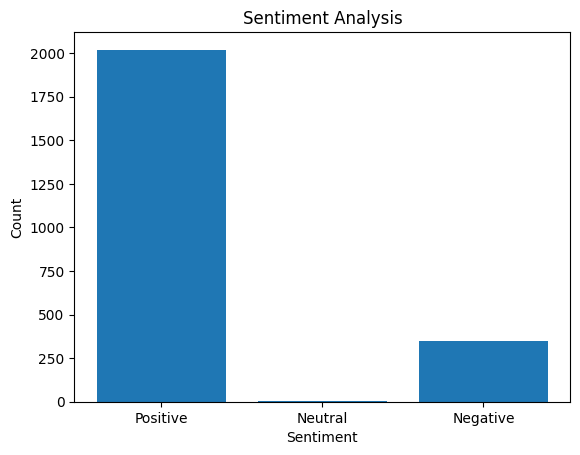

In [79]:
# Assuming you have a DataFrame 'df' with 'sentiment' column
sentiment_counts = df5.groupby('sentiment').count().toPandas()

# Plotting the bar graph
plt.bar(sentiment_counts['sentiment'], sentiment_counts['count'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis')
plt.show()



**Movie Recommendation**

In [80]:
from pyspark.sql.functions import regexp_replace

df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Adventure,", "Adventure ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Comedy,", "Comedy ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Mystery & thriller,", "Mystery thriller ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Horror,", "Horror ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Kids & family,", "Kids & family ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Sci-fi,", "Sci-fi ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Romance,", "Romance ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Action,", "Action ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Western,", "Western ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Drama,", "Drama ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Kids & family", "Kids family ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Mystery & thriller", "Mystery thriller ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Fantasy,", "Fantasy ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Musical,", "Musical ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Holiday,", "Holiday ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Crime,", "Crime ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "War,", "War ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Lgbtq+,", "Lgbtq+ ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Biography,", "Biography ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "History,", "History ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Gay & lesbian,", "Gay & lesbian ")
                    .cast("string"))
df5 = df5.withColumn("genre", regexp_replace(df5["genre"], "Gay & lesbian", "Gay lesbian ")
                    .cast("string"))

In [81]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer
from pyspark.sql.functions import col

df5 = df5.withColumn("index", monotonically_increasing_id()).drop("index")

df5 = df5.withColumn("combined_features", concat(col("overview"), lit(" "), col("genre")))

# Create the pipeline
tokenizer = RegexTokenizer(inputCol="combined_features", outputCol="words", pattern="\\W")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
countVectorizer = CountVectorizer(inputCol="filtered_words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
assembler = VectorAssembler(inputCols=["features"], outputCol="feature_vector")
normalizer = Normalizer(inputCol="feature_vector", outputCol="normalized_features")
pipeline = Pipeline(stages=[tokenizer, remover, countVectorizer, idf, assembler, normalizer])

# Fit the pipeline to the data
pipeline_model = pipeline.fit(df5)
df_transformed = pipeline_model.transform(df5)

# Define a UDF for cosine similarity
def cosine_similarity(v1, v2):
    return float(v1.dot(v2) / (v1.norm(2) * v2.norm(2)))

cosine_similarity_udf = udf(cosine_similarity)


df_similarity = df_transformed.alias("df1").crossJoin(df_transformed.alias("df2"))
df_similarity = df_similarity.withColumn("similarity", cosine_similarity_udf(col("df1.normalized_features"), col("df2.normalized_features")))

movie_name = input('Enter your favourite movie name: ')
df_selected = df_similarity.filter(col("df1.title") == movie_name)

df_selected = df_selected.orderBy(col("similarity").desc())

recommended_movies = df_selected.select("df2.title").limit(10)

print('Movies suggested for you:\n')
recommended_movies.show(truncate=False)

Enter your favourite movie name: 13 Minutes
Movies suggested for you:

+---------------------------+
|title                      |
+---------------------------+
|Parker                     |
|Salmon Fishing in the Yemen|
|Of Gods and Men            |
|Love Liza                  |
|Dreamgirls                 |
|Inside I'm Dancing         |
|The Descendants            |
|Parasite                   |
|Jackpot                    |
|The Merchant of Venice     |
+---------------------------+



**###############################################################################**

### **Seperate Second Dataset** 

**Reading the dataset**

In [82]:
df20= spark.read.csv("/content/drive/MyDrive/BigData/mubi_movie_data.csv", header=True, inferSchema=True)
df20.take(5)

[Row(movie_id=1, movie_title='La Antena', movie_release_year='2007.0', movie_url='http://mubi.com/films/la-antena', movie_title_language='en', movie_popularity='105', movie_image_url='https://images.mubicdn.net/images/film/1/cache-7927-1581389497/image-w1280.jpg', director_id='131', director_name='Esteban Sapir', director_url='http://mubi.com/cast/esteban-sapir'),
 Row(movie_id=2, movie_title='Elementary Particles', movie_release_year='2006.0', movie_url='http://mubi.com/films/elementary-particles', movie_title_language='en', movie_popularity='23', movie_image_url='https://images.mubicdn.net/images/film/2/cache-512179-1581389841/image-w1280.jpg', director_id='73', director_name='Oskar Roehler', director_url='http://mubi.com/cast/oskar-roehler'),
 Row(movie_id=3, movie_title="It's Winter", movie_release_year='2006.0', movie_url='http://mubi.com/films/its-winter', movie_title_language='en', movie_popularity='21', movie_image_url='https://images.mubicdn.net/images/film/3/cache-7929-148153

In [83]:
num_rows = 10
df1.show(num_rows)

+--------------------+--------------------+-------------+-----------+------+--------------------+--------------------+--------------+--------------------+----------------+----------------+--------------------+---------+--------------------+--------------------+
|                  id|               title|audienceScore|tomatoMeter|rating|      ratingContents|releaseDateStreaming|runtimeMinutes|               genre|originalLanguage|        director|              writer|boxOffice|         distributor|            soundMix|
+--------------------+--------------------+-------------+-----------+------+--------------------+--------------------+--------------+--------------------+----------------+----------------+--------------------+---------+--------------------+--------------------+
|     monsoon_wedding|     Monsoon Wedding|           87|         95|     R|['Some Sex Relate...|          2002-09-24|           100|       Comedy, Drama|         English|       Mira Nair|      Sabrina Dhawan|   $1

In [84]:
df21 = spark.read.csv("/content/drive/MyDrive/BigData/mubi_ratings_data.csv",header=True, inferSchema=True)
df21.take(5)

[Row(movie_id='1066', rating_id='15610495', rating_url='http://mubi.com/films/pavee-lackeen-the-traveller-girl/ratings/15610495', rating_score='3.0', rating_timestamp_utc='2017-06-10 12:38:33', critic=None, critic_likes='0', critic_comments='0', user_id='41579158', user_trialist='False', user_subscriber='False', user_eligible_for_trial='True', user_has_payment_method='False'),
 Row(movie_id='1066', rating_id='10704606', rating_url='http://mubi.com/films/pavee-lackeen-the-traveller-girl/ratings/10704606', rating_score='2.0', rating_timestamp_utc='2014-08-15 23:42:31', critic=None, critic_likes='0', critic_comments='0', user_id='85981819', user_trialist='True', user_subscriber='True', user_eligible_for_trial='False', user_has_payment_method='True'),
 Row(movie_id='1066', rating_id='10177114', rating_url='http://mubi.com/films/pavee-lackeen-the-traveller-girl/ratings/10177114', rating_score='2.0', rating_timestamp_utc='2014-01-30 13:21:57', critic=None, critic_likes='0', critic_comments='

In [85]:
num_rows = 10
df21.show(num_rows)

+--------+---------+--------------------+------------+--------------------+--------------------+------------+---------------+--------+-------------+---------------+-----------------------+-----------------------+
|movie_id|rating_id|          rating_url|rating_score|rating_timestamp_utc|              critic|critic_likes|critic_comments| user_id|user_trialist|user_subscriber|user_eligible_for_trial|user_has_payment_method|
+--------+---------+--------------------+------------+--------------------+--------------------+------------+---------------+--------+-------------+---------------+-----------------------+-----------------------+
|    1066| 15610495|http://mubi.com/f...|         3.0| 2017-06-10 12:38:33|                null|           0|              0|41579158|        False|          False|                   True|                  False|
|    1066| 10704606|http://mubi.com/f...|         2.0| 2014-08-15 23:42:31|                null|           0|              0|85981819|         True|

**Cleaning (Nulls, Duplicates, Unwanted Columns)**

In [86]:
#Checking null values
for column in df20.columns:
   null_count = df20.filter(col(column).isNull() | isnan(col(column))).count()
   if null_count > 0:
    print(f"Column '{column}' has {null_count} null value(s).")

Column 'movie_release_year' has 5 null value(s).
Column 'movie_image_url' has 17418 null value(s).
Column 'director_name' has 3 null value(s).


In [87]:
#Dropping null values
df20= df20.na.drop()

In [88]:
for column in df20.columns:
  null_count = df20.filter(col(column).isNull() | isnan(col(column))).count()
  if null_count > 0:
    print(f"Column '{column}' has {null_count} null value(s).")
if null_count == 0:
  print("Done")

Done


In [89]:
#Checking duplicates
duplicate_rows = df20.groupBy(df20.columns).count().filter(col('count') > 1)
duplicate_rows.show()

+--------+-----------+------------------+---------+--------------------+----------------+---------------+-----------+-------------+------------+-----+
|movie_id|movie_title|movie_release_year|movie_url|movie_title_language|movie_popularity|movie_image_url|director_id|director_name|director_url|count|
+--------+-----------+------------------+---------+--------------------+----------------+---------------+-----------+-------------+------------+-----+
+--------+-----------+------------------+---------+--------------------+----------------+---------------+-----------+-------------+------------+-----+



In [90]:
# Drop unwanted columns
columns_to_drop = ['movie_image_url', 'director_url', 'movie_url']

df20= df20.drop(*columns_to_drop)

df20.show()


+--------+--------------------+------------------+--------------------+----------------+-----------+--------------------+
|movie_id|         movie_title|movie_release_year|movie_title_language|movie_popularity|director_id|       director_name|
+--------+--------------------+------------------+--------------------+----------------+-----------+--------------------+
|       1|           La Antena|            2007.0|                  en|             105|        131|       Esteban Sapir|
|       2|Elementary Particles|            2006.0|                  en|              23|         73|       Oskar Roehler|
|       3|         It's Winter|            2006.0|                  en|              21|         82|          Rafi Pitts|
|       4|Kirikou and the W...|            2005.0|                  en|              46|     89, 90|Michel Ocelot, Bé...|
|       5|       Padre Nuestro|            2007.0|                  en|               7|         92|   Christopher Zalla|
|       6|The Perfume of

In [91]:
for column in df21.columns:
   null_count = df21.filter(col(column).isNull() | isnan(col(column))).count()
   if null_count > 0:
    print(f"Column '{column}' has {null_count} null value(s).")

Column 'movie_id' has 10 null value(s).
Column 'rating_id' has 25574 null value(s).
Column 'rating_url' has 29041 null value(s).
Column 'rating_score' has 57128 null value(s).
Column 'rating_timestamp_utc' has 30918 null value(s).
Column 'critic' has 14802249 null value(s).
Column 'critic_likes' has 74444 null value(s).
Column 'critic_comments' has 75595 null value(s).
Column 'user_id' has 98376 null value(s).
Column 'user_trialist' has 104951 null value(s).
Column 'user_subscriber' has 107502 null value(s).
Column 'user_eligible_for_trial' has 108619 null value(s).
Column 'user_has_payment_method' has 109127 null value(s).


In [92]:
df21 = df21.na.drop()

In [93]:
for column in df21.columns:
  null_count = df21.filter(col(column).isNull() | isnan(col(column))).count()
  if null_count > 0:
    print(f"Column '{column}' has {null_count} null value(s).")
if null_count == 0:
  print("Done")

Done


In [94]:
duplicate_rows = df21.groupBy(df21.columns).count().filter(col('count') > 1)
duplicate_rows.show()

+--------------------+---------+----------+------------+--------------------+------------------+------------+---------------+--------+-------------+---------------+-----------------------+-----------------------+-----+
|            movie_id|rating_id|rating_url|rating_score|rating_timestamp_utc|            critic|critic_likes|critic_comments| user_id|user_trialist|user_subscriber|user_eligible_for_trial|user_has_payment_method|count|
+--------------------+---------+----------+------------+--------------------+------------------+------------+---------------+--------+-------------+---------------+-----------------------+-----------------------+-----+
|Just watching thi...|   Acting| Directing| Photography| Sound.. Instant ...| All time Top 10."|           0|              0|85577313|        False|          False|                   True|                   True|    2|
+--------------------+---------+----------+------------+--------------------+------------------+------------+---------------

In [95]:
columns_to_drop = ["critic", "user_trialist","user_subscriber","user_eligible_for_trial","user_has_payment_method","user_id","rating_url","rating_timestamp_utc","rating_id"]

In [96]:
df21 = df21.drop(*columns_to_drop)

In [97]:
df21.show()

+--------+------------+--------------------+--------------------+
|movie_id|rating_score|        critic_likes|     critic_comments|
+--------+------------+--------------------+--------------------+
|    1066|         3.0|                   0|                   0|
|    1067|         5.0|                   0|                   0|
|    1068|         2.0|                   0|                   0|
|    1068|         1.0|                   0|                   0|
|    1068|         1.0|                   0|                   0|
|    1068|         2.0|                   1|                   0|
|    1068|         1.0|                   1|                   2|
|    1068|         2.0|                   0|                   0|
|    1069|         1.0|                   0|                   0|
|    1069|         4.0|                   0|                   0|
|    1069|         2.0|                   0|                   0|
|    1069|         2.0|                   0|                   0|
|    1069|

**Integration**

In [98]:
join_column = "movie_id"
df23 = df20.join(df21, join_column , "inner")
df23.show()

+--------+-----------+------------------+--------------------+----------------+-----------+-------------+------------+--------------------+--------------------+
|movie_id|movie_title|movie_release_year|movie_title_language|movie_popularity|director_id|director_name|rating_score|        critic_likes|     critic_comments|
+--------+-----------+------------------+--------------------+----------------+-----------+-------------+------------+--------------------+--------------------+
|       1|  La Antena|            2007.0|                  en|             105|        131|Esteban Sapir|         5.0|                   0|                   0|
|       1|  La Antena|            2007.0|                  en|             105|        131|Esteban Sapir|         1.0|                   0|                   0|
|       1|  La Antena|            2007.0|                  en|             105|        131|Esteban Sapir|         4.0|                   0|                   0|
|       1|  La Antena|            

**Correlation analysis**

In [99]:
min_value = df23.agg(min('movie_release_year')).collect()[0][0]

max_value = df23.agg(max('movie_release_year')).collect()[0][0]

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 1878.0
Maximum value: 2021.0


Correlation between release year and popularity within the range 1878.0-2021.0: -0.15439621846947335


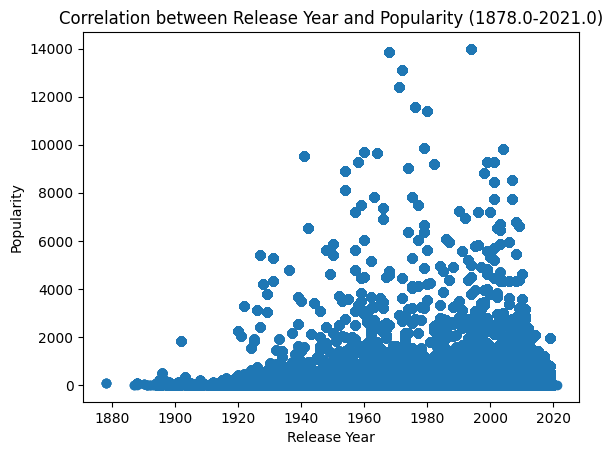

In [100]:
corr_columns = df23.select(df23["movie_release_year"].cast("int"), df23["movie_popularity"].cast("double")) #casting columns into numerical to be able to make correlation between release year and popualrity

start_year = min_value #defining correlation start  
end_year = max_value    #defining correlation end 

filtered_df = corr_columns.filter((corr_columns["movie_release_year"] >= start_year) & (corr_columns["movie_release_year"] <= end_year)) #cheking the year if its inside the limits or not
correlation = filtered_df.select(corr("movie_release_year", "movie_popularity")).collect()[0][0]         #applying correlation function

print(f"Correlation between release year and popularity within the range {start_year}-{end_year}: {correlation}")  #printing the number of correlation as it shown down there is a negative correlation

release_years = filtered_df.select("movie_release_year").rdd.flatMap(lambda x: x).collect() #flatmap is here to convert the nested structure as tuples and 2d lists into flat structure 
popularity = filtered_df.select("movie_popularity").rdd.flatMap(lambda x: x).collect()     #in these two columns


plt.scatter(release_years, popularity)  #plotting the correlation
plt.xlabel("Release Year")
plt.ylabel("Popularity")
plt.title(f"Correlation between Release Year and Popularity ({start_year}-{end_year})")
plt.show()

**Which Director has the highest average movie popualrity ?**

In [101]:
df23.dtypes  

[('movie_id', 'int'),
 ('movie_title', 'string'),
 ('movie_release_year', 'string'),
 ('movie_title_language', 'string'),
 ('movie_popularity', 'string'),
 ('director_id', 'string'),
 ('director_name', 'string'),
 ('rating_score', 'string'),
 ('critic_likes', 'string'),
 ('critic_comments', 'string')]

In [102]:
dir_pop = df23.select(df23["director_Name"], df23["movie_popularity"].cast("double")) #casting these two columns to be able to work in it

avg_popularity_df = dir_pop.groupBy("director_name").agg(avg("movie_popularity").alias("average_popularity")) #grouping by the director name and calculating the average of popularity
sorted_df = avg_popularity_df.orderBy(desc("average_popularity"))  #sorting data in descending order

highest_popularity_director = sorted_df.select("director_name").first()[0] #select the director with the highest avg popularity
print(f"The director with the highest average movie popularity is: {highest_popularity_director}") 

The director with the highest average movie popularity is: Stanley Kubrick


**Graph to see increasing with movie popularity in years**

In [103]:
#sorting the number of values in years descending to limit the range of graph  
yearCount = df23.filter(df23["movie_title_language"] == "en").groupBy("movie_release_year").count()   #grouping the years with language english language 

sortedYearCount = yearCount.sort(desc("count"))  #sorting years descending

maxCount = sortedYearCount.agg(max("count")).collect()[0][0]  #getting the number of movies to get the max years that have most counts 

sortedYearCount.show() 

# print(maxCount)

+------------------+-----+
|movie_release_year|count|
+------------------+-----+
|            2015.0|32612|
|            2016.0|32081|
|            2014.0|30626|
|            2017.0|30321|
|            2013.0|29651|
|            2011.0|29048|
|            2012.0|27588|
|            2010.0|24272|
|            2018.0|23665|
|            2009.0|22777|
|            2019.0|16185|
|            2008.0|15312|
|            2007.0|14101|
|            2006.0|12521|
|            2004.0|11505|
|            2005.0|10312|
|            2003.0|10026|
|            2001.0| 9511|
|            2002.0| 9231|
|            2000.0| 8791|
+------------------+-----+
only showing top 20 rows



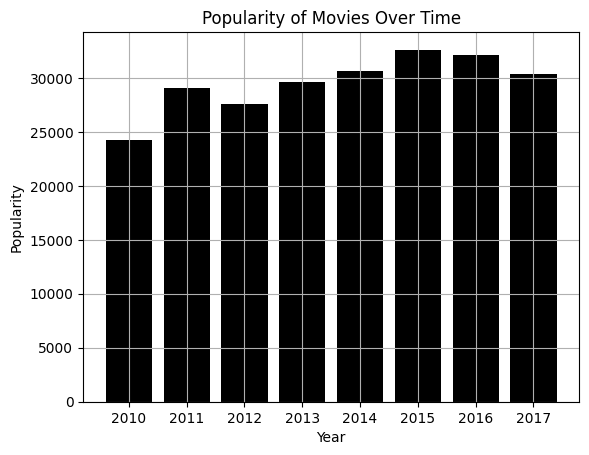

In [104]:
movie_release_year = [2010,2012, 2011, 2013, 2017, 2014,2016, 2015]
movie_popularity =[24272,27588,29048,29651,30321,30626, 32081,32612] 
  #[5, 8, 12, 15, 20, 25, 27, 30]

# Create a Spark DataFrame with the data
data = zip(movie_release_year, movie_popularity)
df = spark.createDataFrame(data, ["Year", "Popularity"])

# Extract the data from the Spark DataFrame
x_values = df.select("Year").rdd.flatMap(lambda x: x).collect()
y_values = df.select("Popularity").rdd.flatMap(lambda x: x).collect()

# Plotting the popularity trend using Matplotlib
plt.bar(x_values, y_values, linestyle='-', color='black')
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.title('Popularity of Movies Over Time')
plt.grid(True)
plt.show()

**The year of the highest english movies released ?**

In [105]:
column_name = "movie_title_language"
unique_values = df23.select(column_name).distinct().collect()
unique_values_list = [row[column_name] for row in unique_values]
print(unique_values_list)

['en']


In [106]:
english_movies_df = df23.filter(col("movie_title_language") == "en")
year_counts_df = english_movies_df.groupBy("movie_release_year").count()

sorted_year_counts_df = year_counts_df.sort(col("count").desc())
highest_count_year = sorted_year_counts_df.select("movie_release_year").first()[0]

print(f"The year with the highest number of English movies released is: {highest_count_year}")

The year with the highest number of English movies released is: 2015.0
